# Topic Modeling

## To import all modules

In [4]:
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan
from umap import UMAP

/Users/osakiyutaka/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## To load dataset and make it tidy

In [12]:
data = pd.read_csv('data/dataset.csv')
data = data[['book', 'chapter', 'content']]


In [13]:
# read output.txt file, and load it into the data dataframe, as a new column called 'segmented'
if os.path.exists('data/word_segmentation.txt'):
    with open('data/word_segmentation.txt', 'r') as f:
        lines = f.readlines()
    data['segmented'] = lines

In [14]:
data.head()

,book,chapter,content,segmented
0,analects,學而,子曰：「學而時習之，不亦說乎？有朋自遠方來，不亦樂乎？人不知而不慍，不亦君子乎？」\n\n有...,子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不 ...
1,analects,為政,子曰：「為政以德，譬如北辰，居其所而眾星共之。」\n\n子曰：「詩三百，一言以蔽之，曰『思無...,子 曰 为 政 以 德 譬 如 北 辰 居 其 所 而 众 星 共 之 子 曰 诗 三百 一...
2,analects,八佾,孔子謂季氏：「八佾舞於庭，是可忍也，孰不可忍也？」\n\n三家者以雍徹。子曰：「『相維辟公，...,孔子 谓 季 氏 八 佾 舞 于 庭 是 可 忍 也 孰 不 可 忍 也 三 家 者 以 雍...
3,analects,里仁,子曰：「里仁為美。擇不處仁，焉得知？」\n\n子曰：「不仁者不可以久處約，不可以長處樂。仁者...,子 曰 里 仁 为 美 择 不 处 仁 焉 得 知 子 曰 不 仁 者 不 可 以 久 处 ...
4,analects,公冶長,子謂公冶長，「可妻也。雖在縲絏之中，非其罪也」。以其子妻之。\n\n子謂南容，「邦有道，不廢...,子 谓 公冶 长 可 妻 也 虽 在 缧 绁 之 中 非 其 罪 也 以 其 子 妻 之 子...


## To add time attributes

In [15]:
list_bookname = list(data["book"].unique())
list_book_time = [
    ['analects',-480, -350],
    ['mengzi',  -340, -250],
    ['liji',    -475, -221],
    ['xunzi',   -475, -221],
    ['xiao-jing',-475, -221],
    ['shuo-yuan',-206, 9],
    ['chun-qiu-fan-lu',-206, 9],
    ['han-shi-wai-zhuan',-180, -120],
    ['da-dai-li-ji',100, 200],
    ['bai-hu-tong',79, 92],
    ['xin-shu', -206, 9],
    ['xin-xu',-206, 9],
    ['yangzi-fayan',-33, 18],
    ['zhong-lun',25, 220],
    ['kongzi-jiayu',-206, 220],
    ['qian-fu-lun',102, 167],
    ['lunheng', 80, 80],
    ['taixuanjing',-33, 18],
    ['fengsutongyi',190, 200],
    ['kongcongzi',25, 265],
    ['shenjian',196, 220],
    ['zhong-jing',100,166],
    ['su-shu',-250,-186],
    ['xinyu',-196, -196],
    ['duduan',167, 258],
    ['caizhong-langji', 152, 192]
]
def map_year(year):
    return int(year/2 + 2000)
def set_time_attributes(df):
    """
    This function sets the time attributes "Start", "End", and "era" for each book in the input dataframe.

    Parameters:
    df (pandas.DataFrame): The input dataframe. It should contain a column named "book".

    Returns:
    pandas.DataFrame: The input dataframe with three new columns: "Start", "End", and "era". Each row represents a book.
    - "Start" is the start year of the book.
    - "End" is the end year of the book.
    - "era" is the average of the start year and the end year.
    """
    df["Start"] = None  # Initialize the "Start" column
    df["End"] = None  # Initialize the "End" column
    df["average_year"] = None
    df['mapped_year'] = None
    num = list_bookname.index(df.iloc[0]["book"])  # Get the index of the first book in the list of book names
    for i in range(df.shape[0]):  # For each row in the dataframe
        num = list_bookname.index(df.iloc[i]["book"])  # Get the index of the book in the list of book names
        df.loc[i, 'Start'] = list_book_time[num][1]  # Set the "Start" attribute
        df.loc[i, 'End'] = list_book_time[num][2]  # Set the "End" attribute
    for i in range(df.shape[0]):  # For each row in the dataframe
        df.loc[i, 'average_year'] = int((df.loc[i, 'Start']+df.loc[i, 'End'])/2)
    df['mapped_year'] = df['average_year'].apply(map_year)
    return df  # Return the dataframe with the new attributes

# Bertopic

In [20]:
data = set_time_attributes(data)
data = data[["book", "chapter", "segmented", "average_year", "mapped_year"]]
data['contain_ren'] = data['segmented'].apply(lambda x: 1 if '仁' in x else 0)
data.head()

In [22]:
# Create a new DataFrame 'ren_data' that contains only the sentences that contain the character '仁'
ren_data = data[data['contain_ren'] == 1].copy()
# drop the 'contain_ren' column
ren_data.drop('contain_ren', axis=1, inplace=True)
ren_data.reset_index(drop=True, inplace=True)
data_set=[]

# store the sentences in the 'segmented' column to the data_set list
for sentence in ren_data['segmented']:
    data_set.append(sentence)
print(len(data_set))

In [24]:
# Check if CUDA is available and set the device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the tokenizer and model from the pretrained BERT model for ancient Chinese
tokenizer = AutoTokenizer.from_pretrained("Jihuai/bert-ancient-chinese")
model = AutoModel.from_pretrained("Jihuai/bert-ancient-chinese").to(device)

def split_sentence(sentence, max_length=512):
    """
    Split a sentence into chunks of max_length tokens each.
    Args:
        sentence (str): The sentence to be split.
        max_length (int): The maximum number of tokens for each chunk.
    Returns:
        list of str: The chunks of the sentence.
    """
    tokens = tokenizer.tokenize(sentence)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return [tokenizer.convert_tokens_to_string(chunk) for chunk in chunks]

def compute_max_chunks(sentences, max_length=512):
    """
    Compute the maximum number of chunks a sentence can be split into.
    Args:
        sentences (list of str): The sentences to be split.
        max_length (int): The maximum number of tokens for each chunk.
    Returns:
        int: The maximum number of chunks.
        list of int: The number of chunks for each sentence.
    """
    max_chunks = 0
    sentence_chunk_counts = []
    for sentence in sentences:
        chunks = split_sentence(sentence, max_length=max_length)
        chunk_count = len(chunks)
        sentence_chunk_counts.append(chunk_count)
        if chunk_count > max_chunks:
            max_chunks = chunk_count
    return max_chunks, sentence_chunk_counts

def encode_sentences(model, tokenizer, sentences, max_chunks, batch_size=32, max_length=512, show_progress_bar=False):
    """
    Encode sentences into embeddings.
    Args:
        model (torch.nn.Module): The model to use for encoding.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for encoding.
        sentences (list of str): The sentences to encode.
        max_chunks (int): The maximum number of chunks a sentence can be split into.
        batch_size (int): The number of sentences to process at a time.
        max_length (int): The maximum number of tokens for each chunk.
        show_progress_bar (bool): Whether to show a progress bar.
    Returns:
        numpy.ndarray: The embeddings for the sentences.
    """
    all_embeddings = []
    sentence_chunk_counts = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        batch_embeddings = []
        for sentence in batch:
            chunks = split_sentence(sentence, max_length=max_length)
            sentence_chunk_counts.append(len(chunks))
            encoded_input = tokenizer(chunks, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
            with torch.no_grad():
                model_output = model(**encoded_input)
            sentence_embeddings = model_output.last_hidden_state.mean(dim=1)
            batch_embeddings.append(sentence_embeddings)
        all_embeddings.extend(batch_embeddings)
        if show_progress_bar:
            print(f"Processed {i+batch_size}/{len(sentences)} sentences")
    extended_embeddings = []
    for sentence_embeddings, chunk_count in zip(all_embeddings, sentence_chunk_counts):
        padding = torch.zeros((max_chunks - chunk_count, sentence_embeddings.shape[1])).to(device)
        extended_embedding = torch.cat([sentence_embeddings, padding], dim=0).flatten()
        extended_embeddings.append(extended_embedding)
    
    return torch.stack(extended_embeddings).cpu().numpy()

# Compute the maximum number of chunks a sentence can be split into
max_chunks, sentence_chunk_counts = compute_max_chunks(data_set, max_length=512)

# Encode the sentences into embeddings
embeddings = encode_sentences(model, tokenizer, data_set, max_chunks, batch_size=32, max_length=512, show_progress_bar=True)

print(embeddings.shape)

# Save the embeddings to a file
np.save('embeddings.npy', embeddings)

Using device: cpu


Some weights of BertModel were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 32/346 sentences
Processed 64/346 sentences
Processed 96/346 sentences
Processed 128/346 sentences
Processed 160/346 sentences
Processed 192/346 sentences
Processed 224/346 sentences
Processed 256/346 sentences
Processed 288/346 sentences
Processed 320/346 sentences
Processed 352/346 sentences
(346, 16128)


In [46]:
embeddings = np.load('data/embeddings.npy')
print(embeddings.shape, ren_data.shape)

(346, 16128) (346, 5)


In [47]:
timestamp = ren_data['mapped_year'].tolist()
unique_years = list(set(timestamp))
print(unique_years)

[1792, 1925, 2061, 2066, 2067, 2072, 2075, 1951, 1826, 2086, 2097, 2104, 2106, 1852, 1996, 2003, 1891, 1902, 2040, 2042]


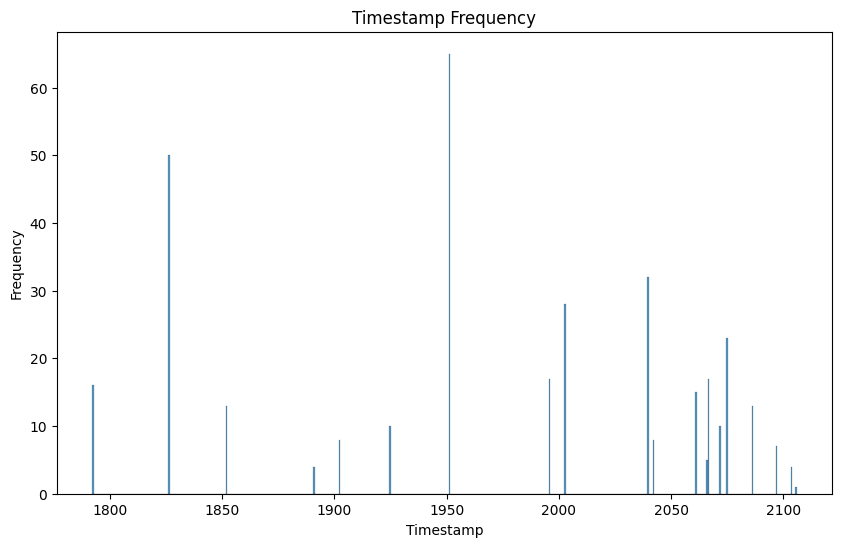

In [48]:

plt.figure(figsize=(10, 6))
sns.histplot(timestamp, bins=500)
plt.title('Timestamp Frequency')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

### Easy bertopic

In [49]:
# Load stop words from a text file
stop_word = [line.strip() for line in open('data/stop_word.txt','r',encoding='utf-8')]
# Initialize a CountVectorizer with the stop words
vectorizer_model = CountVectorizer(stop_words=stop_word,analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")
# Initialize a BERTopic model with the CountVectorizer and set the number of topics to be determined automatically
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model, nr_topics='auto')
# Fit the BERTopic model to the data and embeddings
topic = topic_model.fit(data_set, embeddings)
# Get information about the topics
topic.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,77,0_王_天_子_下,"[王, 天, 子, 下, 君, 公, 知, 大, 能, 国]",[鲁 哀 公 问 子夏 曰 必 学 而 后 可 以 安 国 保 民 乎 子夏 曰 不 学 而...
1,1,65,1_孔子_天_民_子,"[孔子, 天, 民, 子, 此, 行, 言, 知, 问, 仁]",[公 曰 四 代 之 政 刑 论 其 明 者 可 以 为 法 乎 子 曰 何 哉 四 代 之...
2,2,60,2_子_天_行_道,"[子, 天, 行, 道, 礼, 仁, 民, 如, 君子, 此]",[孔子 曰 君子 之 道 譬 犹 防 与 夫 礼 之 塞 乱 之 所 从 生 也 ； 犹 防...
3,3,42,3_公_王_君_下,"[公, 王, 君, 下, 天, 子, 大, 臣, 国, 能]",[圣 人 之 于 天 下 百 姓 也 其 犹 赤 子 乎 饥 者 则 食 之 寒 者 则 衣...
4,4,40,4_能_言_行_孔子,"[能, 言, 行, 孔子, 然, 知, 善, 非, 君, 生]",[卫 将 军 文子 问 于 子贡 曰 吾 闻 孔子 之 施 教 也 先 之 以 《 诗 》 ...
5,5,34,5_天_王_大_能,"[天, 王, 大, 能, 孟子, 知, 生, 子, 礼, 与]",[孟子 曰 尽 其 心 者 知 其 性 也 知 其 性 则 知 天 矣 存 其 心 养 其 ...
6,6,28,6_测_仁_君子_次,"[测, 仁, 君子, 次, 忠, 道, 行, 子, 大, 天]",[子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不...


In [57]:
# Visualize the topics
topic_model.visualize_topics()

In [54]:
# Compute the topics over time with global and evolution tuning
topics_over_time = topic_model.topics_over_time(data_set, timestamp, global_tuning=True, 
                                                evolution_tuning=True, nr_bins=20, datetime_format="%Y")
# Visualize the topics over time for the top 2 topics
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=7)

### finetuning bertopic

In [55]:
# Initialize a UMAP model with specific parameters
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
# Initialize a HDBSCAN model with specific parameters
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, cluster_selection_method='eom', prediction_data=True)
# Load stop words from a text file
stop_word = [line.strip() for line in open('data/stop_word.txt','r',encoding='utf-8')]
# Initialize a CountVectorizer with the stop words and a minimum document frequency of 3
vectorizer_model = CountVectorizer(stop_words=stop_word,analyzer='word', token_pattern=u"(?u)\\b\\w+\\b", min_df=3)
# Initialize a BERTopic model with the UMAP model, HDBSCAN model, CountVectorizer, and set the number of topics to be determined automatically
topic_model3 = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, language="multilingual", vectorizer_model=vectorizer_model, top_n_words=30, nr_topics="auto" )
# Fit the BERTopic model to the data and embeddings
topic = topic_model3.fit(data_set, embeddings)
# Get information about the topics
topic_info = topic.get_topic_info() 
topic_info = topic_model3.get_topic_info()
# Get information about the topics one more time
topic.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,75,0_王_天_公_子,"[王, 天, 公, 子, 下, 君, 国, 能, 大, 臣, 知, 言, 得, 与, 行, ...",[齐 宣 王 谓 田 过 曰 吾 闻 儒 者 亲 丧 三 年 君 与 父 孰 重 过 对 曰...
1,1,65,1_孔子_民_天_子,"[孔子, 民, 天, 子, 此, 行, 言, 知, 问, 仁, 道, 如, 德, 君子, 礼...",[公 曰 四 代 之 政 刑 论 其 明 者 可 以 为 法 乎 子 曰 何 哉 四 代 之...
2,2,50,2_天_行_礼_道,"[天, 行, 礼, 道, 此, 民, 地, 德, 下, 事, 治, 明, 大, 必, 仁, ...",[夫 长 于 变 者 不 可 穷 以 诈 通 于 道 者 不 可 惊 以 怪 审 于 辞 者...
3,3,44,3_王_子_天_君,"[王, 子, 天, 君, 下, 大, 知, 道, 能, 公, 臣, 行, 民, 得, 言, ...",[贤 人 君子 者 通 乎 盛 衰 之 时 明 乎 成 败 之 端 察 乎 治 乱 之 纪 ...
4,4,40,4_能_言_行_孔子,"[能, 言, 行, 孔子, 然, 善, 知, 非, 君, 生, 君子, 此, 见, 天, 子...",[卫 将 军 文子 问 于 子贡 曰 吾 闻 孔子 之 施 教 也 先 之 以 《 诗 》 ...
5,5,34,5_天_王_大_能,"[天, 王, 大, 能, 孟子, 生, 知, 礼, 子, 与, 言, 行, 然, 事, 下,...",[孟子 曰 天 时 不 如 地 利 地 利 不 如 人 和 三 里 之 城 七 里 之 郭 ...
6,6,28,6_测_仁_次_君子,"[测, 仁, 次, 君子, 忠, 道, 行, 大, 子, 天, 同, 得, 一, 德, 能,...",[子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不...
7,7,10,7_子_吾_与_仁,"[子, 吾, 与, 仁, 问, 如, 君子, 斯, 子贡, 知, 子路, 道, 夫子, 见,...",[子 曰 述 而 不 作 信 而 好 古 窃 比 于 我 老 彭 子 曰 默 而 识 之 学...


In [56]:
topic_model3.save("bertopic_model.pkl")

2024-06-04 19:05:28,112 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
